# Fictional Employee Data

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random as rand
import datetime as dt
from dateutil.relativedelta import relativedelta as rd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error
#!pip install Faker
from faker import Faker
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix


### Functions

In [2]:
# creates list of birthdate datetime objects based off age
def birthDate(age, date=None):
  if date == None:
    date = dt.datetime.now()
  return [date - rd(years=x,months=rand.randint(-12, 12),days=rand.randint(-31,31)) for x in age]

# creates list with multiple modes
def multimodallist(obs,stdperlist,modes):
    if obs<len(modes):
        raise Exception('obs is less than amount of modes')
    remainder = obs%len(modes)
    listSize =int((obs - remainder)/len(modes))
    multimodal = []
    # combines smaller lists with different modes to equal list with obs observations
    for i in modes:
        multimodal+=np.random.normal(i,stdperlist,listSize).astype(int).tolist()
    if remainder >0:
        multimodal+=np.random.normal(np.mean(multimodal),stdperlist,remainder).astype(int).tolist()
    return multimodal
def probablity_generator(length):
    return [1/length]*length
def ml_data(newColumn,std,mean):
    random = np.random.normal(mean,std,len(newColumn))
    return newColumn + random


### Data Dictionary

In [3]:
np.random.seed(101)
obs = 100000
fake = Faker()
Faker.seed(2)
# age = np.random.normal(50,6,obs).astype(int)
multimodalage = multimodallist(obs,5,[33,45,65])
mbti = ['ISTJ','ISFJ','INFJ','INTJ','ISTP','ISFP','INFP','INTP','ESTP','ESFP','ENFP','ENTP','ESTJ','ESFJ','ENFJ','ENTJ']
percentage = [0.116,0.138,0.015,0.021,0.054,0.088,0.044,0.033,0.043,0.085,0.081,0.032,0.087,0.12,0.025,0.018]
multiplier = ((1-np.array(percentage))*1.8)**3
mbtimultiplier = {}

for i in range(0,len(mbti)):
    mbtimultiplier[mbti[i]] = multiplier[i]

# name = set()
# while len(name) < obs:
#     name.add(fake.name())
# address = set()
# while len(address) < obs:
#     address.add(fake.address())
performance = ['1','2','3','4','5']

data = {'id':list(range(100000,100000+obs)),
        'age': multimodalage,
        'birthDate': birthDate(multimodalage,date=dt.datetime(2023,9,30)),
        'mbti': np.random.choice(mbti,size=obs,p=percentage),
        'performance':np.random.choice(performance,size=obs,p=[0.1,0.1,0.3,0.3,0.2])
        }
df = pd.DataFrame(data)
df['multiplier'] = [mbtimultiplier[x] for x in df['mbti']]
df['score'] = ml_data(((df['age']**2)/100 + df['age']/10 + 20),5,0).apply(lambda x: round(x,2))
df['salary'] = ml_data((df['score']*300+20000*df['multiplier']),10000,0).apply(lambda x: round(x,2))
df['years_worked'] = ml_data(df['age']/30,1,5).apply(lambda x: round(x,2))
df['401k_total'] = (df['salary']*0.05 * df['years_worked']).apply(lambda x: round(x,2))

In [4]:
df.head()

,id,age,birthDate,mbti,performance,multiplier,score,salary,years_worked,401k_total
0,100000,46,1978-01-27,ISFP,2,4.423867,43.04,104078.94,7.78,40486.71
1,100001,36,1986-09-05,ESFP,4,4.467667,34.44,107344.60,6.43,34511.29
2,100002,37,1987-07-16,ESTP,3,5.111558,47.78,121357.52,6.90,41868.34
3,100003,35,1988-05-30,ISTP,5,4.937316,42.18,113841.92,5.09,28972.77
4,100004,36,1987-01-27,ISTJ,3,4.028787,31.93,94434.94,4.90,23136.56


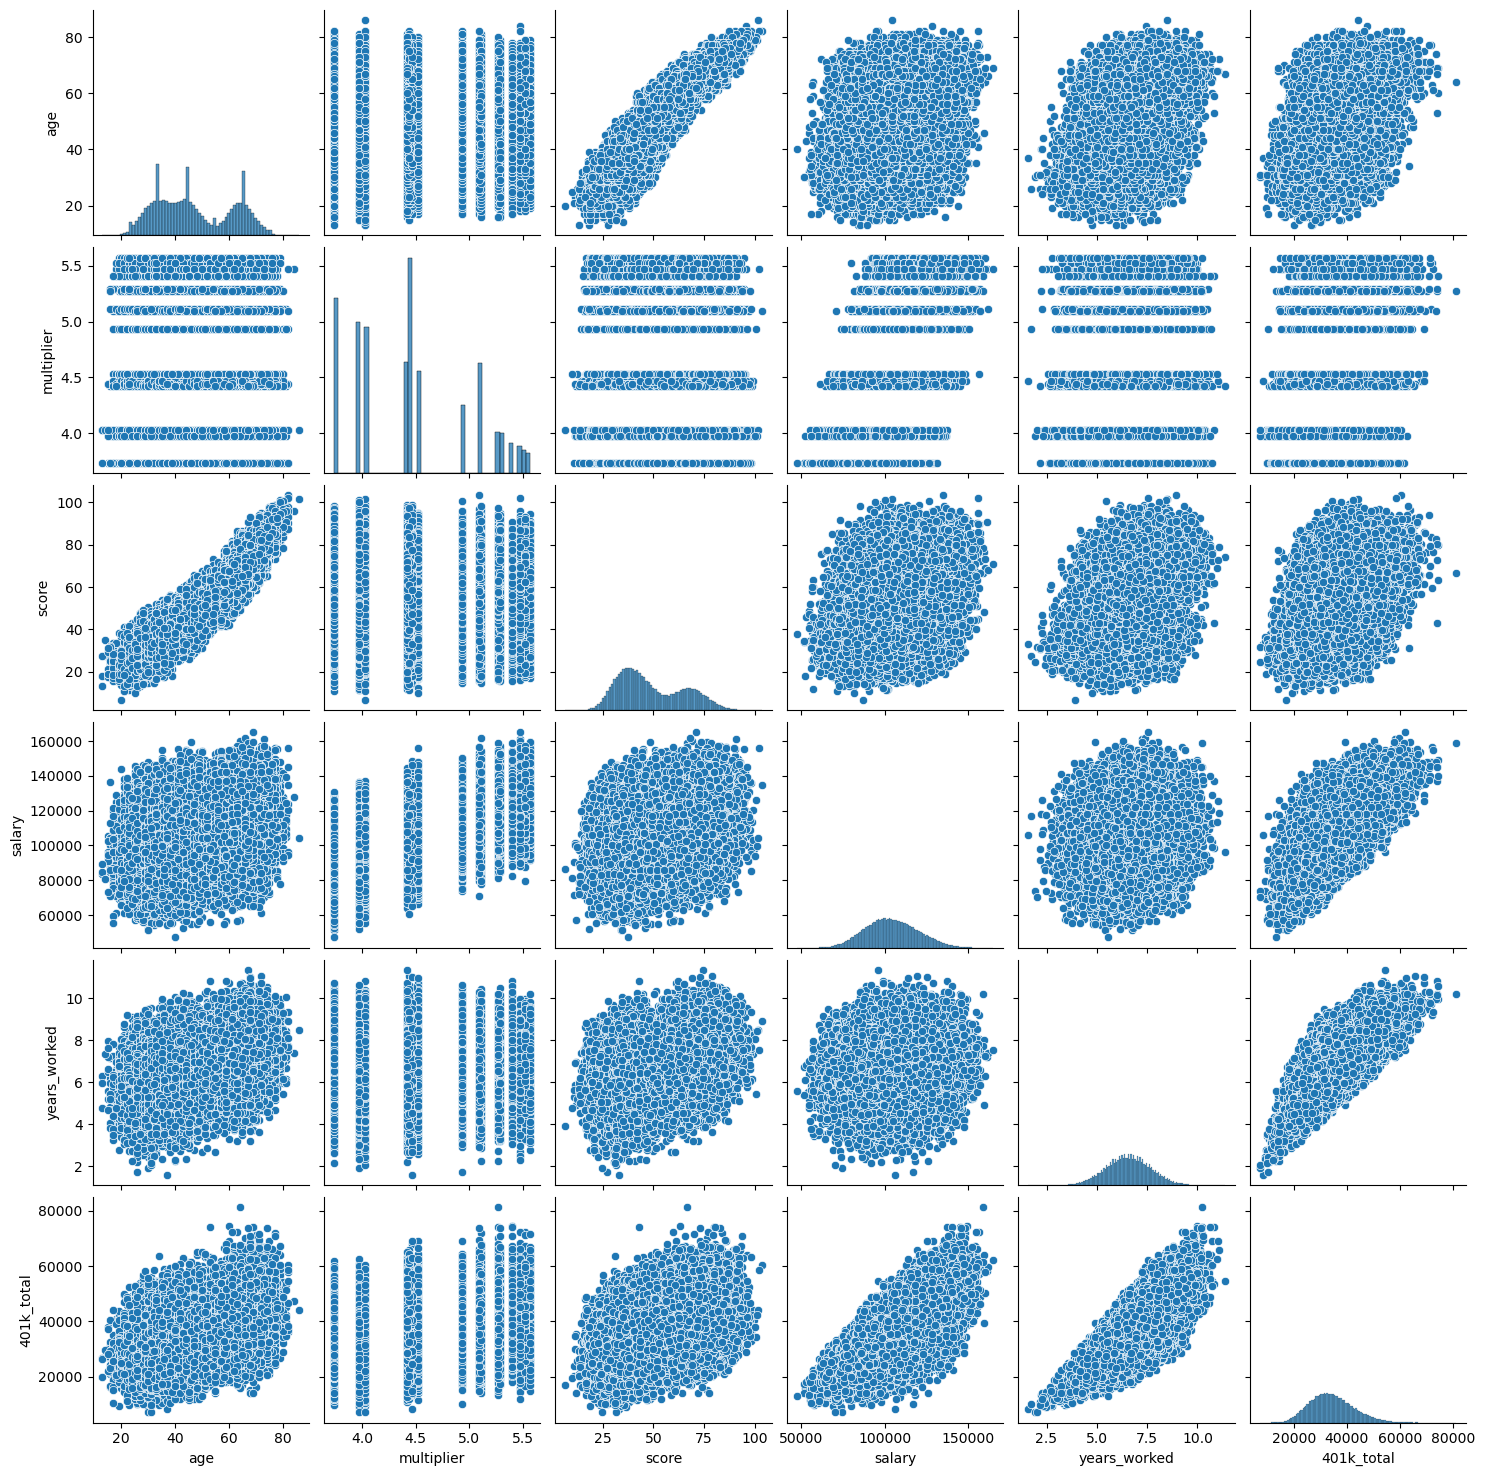

In [5]:
sns.pairplot(df.drop('id',axis=1))

<Axes: xlabel='score', ylabel='salary'>

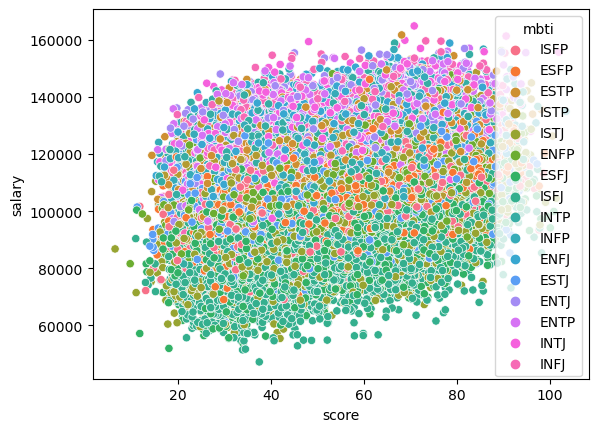

In [6]:
sns.scatterplot(data=df, y='salary', x='score', hue='mbti')

# Machine Learning

In [7]:
data = df[['age','score']]
train, test = train_test_split(
    data, test_size=0.2, random_state=42)

model = smf.ols(
  formula='score ~ age + I(age**2)', data=train).fit()

ols_results_summary = model.summary()

print(ols_results_summary)

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                 3.714e+05
Date:                Wed, 08 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:56:59   Log-Likelihood:            -2.4258e+05
No. Observations:               80000   AIC:                         4.852e+05
Df Residuals:                   79997   BIC:                         4.852e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      19.9843      0.226     88.233      

<Axes: xlabel='age', ylabel='score'>

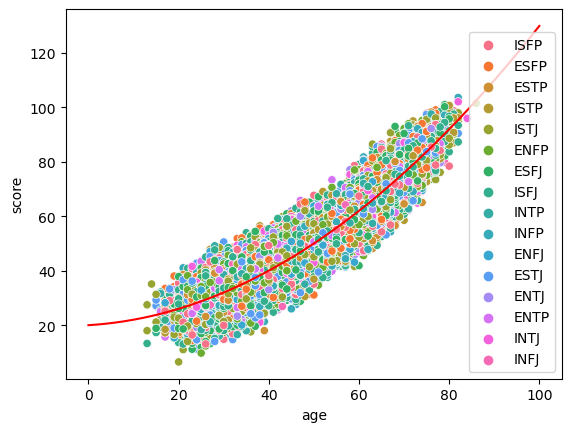

In [8]:
age = pd.DataFrame({'age':np.linspace(0,100,1000)})

score = model.predict(age)

sns.scatterplot(x='age',y='score', data=df, hue='mbti')
sns.lineplot(y=score, x=age['age'],  color='red')

In [9]:
X = df[['salary','score']]
scaler = StandardScaler()
scaled = scaler.fit(X)
X_scaled = scaler.transform(X)
y = df['mbti']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)


# error_rates = []

# for k in range(100, 200, 2):
#     # Creating the k-NN classification model
#     knn = KNeighborsClassifier(n_neighbors=k)
#     knn.fit(X_train, y_train)

#     # Generate predictions on the testing data
#     y_pred_kn = knn.predict(X_test)
#     # Calculate and record proprtion of correct classifications
#     error_rates.append(np.mean(y_pred_kn != y_test))

# # Plot the error rates (which are inverse of AUC).
# plt.figure(figsize=(12, 6))
# plt.plot(range(100, 200, 2), error_rates, color='blue',
#          linestyle=':', marker='x', markersize=5)
# plt.title('Error Rates vs. K Values')
# plt.xlabel('K Value')
# plt.ylabel('Error Rate')


knn = KNeighborsClassifier(n_neighbors=178)
knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)

In [10]:
print(classification_report(y_test,y_pred,zero_division=0.0))

              precision    recall  f1-score   support

        ENFJ       0.11      0.04      0.06       798
        ENFP       0.13      0.11      0.12      2750
        ENTJ       0.11      0.05      0.07       599
        ENTP       0.12      0.09      0.10      1005
        ESFJ       0.19      0.20      0.19      3910
        ESFP       0.12      0.12      0.12      2762
        ESTJ       0.12      0.10      0.11      2864
        ESTP       0.11      0.11      0.11      1437
        INFJ       0.15      0.05      0.07       538
        INFP       0.13      0.14      0.13      1503
        INTJ       0.13      0.06      0.08       668
        INTP       0.12      0.07      0.09      1059
        ISFJ       0.35      0.64      0.45      4582
        ISFP       0.13      0.11      0.12      2861
        ISTJ       0.18      0.13      0.15      3831
        ISTP       0.12      0.15      0.14      1833

    accuracy                           0.19     33000
   macro avg       0.15   

In [11]:
# error_rates = []

# for n in range(1, 50):
#     # Creating the random forest classification model
#     model = RandomForestClassifier(n_estimators=n)
#     model.fit(X_train, y_train)

#     # Generate predictions on the testing data
#     y_pred = model.predict(X_test)
#     # Calculate and record proprtion of correct classifications
#     error_rates.append(np.mean(y_pred != y_test))

# # Plot the error rates (which are inverse of AUC).
# plt.figure(figsize=(12, 6))
# plt.plot(range(1, 50), error_rates, color='blue',
#          linestyle=':', marker='x', markersize=5)
# plt.title('Error Rates vs. N Values')
# plt.xlabel('N Value')
# plt.ylabel('Error Rate')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = RandomForestClassifier(n_estimators=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [31]:
importances = model.feature_importances_
importances ={'features':importances}
featureImportance = pd.DataFrame(importances ,index = X.columns)
print(featureImportance)

        features
salary  0.542759
score   0.457241


In [12]:
print(classification_report(y_test,y_pred,zero_division=0.0))

              precision    recall  f1-score   support

        ENFJ       0.07      0.09      0.08       798
        ENFP       0.10      0.12      0.11      2750
        ENTJ       0.06      0.07      0.06       599
        ENTP       0.09      0.10      0.09      1005
        ESFJ       0.17      0.20      0.18      3910
        ESFP       0.11      0.11      0.11      2762
        ESTJ       0.11      0.11      0.11      2864
        ESTP       0.07      0.07      0.07      1437
        INFJ       0.09      0.07      0.08       538
        INFP       0.09      0.08      0.08      1503
        INTJ       0.06      0.05      0.05       668
        INTP       0.08      0.07      0.08      1059
        ISFJ       0.33      0.37      0.34      4582
        ISFP       0.12      0.10      0.11      2861
        ISTJ       0.16      0.14      0.15      3831
        ISTP       0.10      0.08      0.09      1833

    accuracy                           0.15     33000
   macro avg       0.11   

In [13]:
pd.crosstab(y_pred,y_test,margins=True)

mbti,ENFJ,ENFP,ENTJ,ENTP,ESFJ,ESFP,ESTJ,ESTP,INFJ,INFP,INTJ,INTP,ISFJ,ISFP,ISTJ,ISTP,All
row_0,,,,,,,,,,,,,,,,,
ENFJ,68,67,65,88,14,52,54,106,64,95,54,82,13,42,18,100,982
ENFP,63,336,39,95,325,376,348,163,28,188,47,94,258,372,337,213,3282
ENTJ,53,35,39,47,9,23,30,62,40,71,55,52,5,29,14,43,607
ENTP,69,65,57,100,29,79,65,131,66,107,62,94,13,56,23,130,1146
ESFJ,15,343,11,26,781,369,436,72,8,71,6,33,1012,433,826,128,4570
ESFP,51,311,38,66,333,315,312,121,16,127,41,85,250,319,299,175,2859
ESTJ,44,302,25,59,297,291,306,110,28,128,43,69,284,275,340,186,2787
ESTP,72,121,56,75,60,91,98,100,48,116,76,115,27,100,53,134,1342
INFJ,34,15,42,48,2,13,18,39,39,45,46,46,3,15,9,36,450


### Data Visualization

count    100000.00000
mean         47.17477
std          14.11260
min          13.00000
25%          35.00000
50%          45.00000
75%          61.00000
max          86.00000
Name: age, dtype: float64
Axes(0.125,0.11;0.775x0.77)


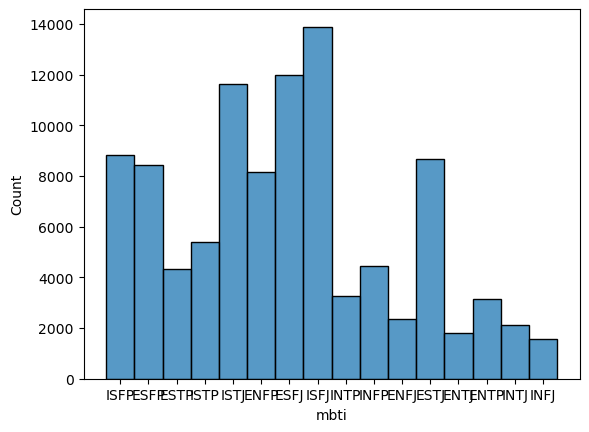

In [14]:
print(df['age'].describe())
print(sns.histplot(df['mbti']))

Axes(0.125,0.11;0.775x0.77)


,id,age,birthDate,mbti,performance,multiplier,score,salary,years_worked,401k_total
4780,104780,31,1993-01-19,ESFJ,5,3.974345,41.18,75678.69,7.15,27055.13
36819,136819,44,1979-05-23,ESFJ,5,3.974345,43.06,110416.46,5.94,32793.69
80592,180592,68,1955-03-20,INTJ,3,5.472246,71.48,120441.53,6.21,37397.10
47149,147149,47,1977-02-09,ENFP,5,4.526516,50.10,121532.96,6.86,41685.81
12555,112555,30,1993-09-05,INFP,4,5.095551,36.68,106831.38,5.41,28897.89


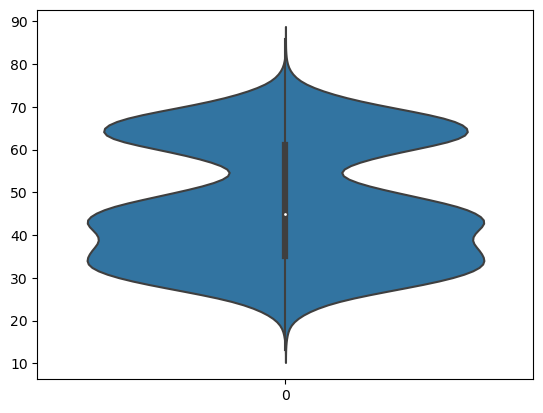

In [15]:
print(sns.violinplot(df['age']))
df.sample(5)

In [16]:
# Check type() of birthData column
type(df['birthDate'][0])

pandas._libs.tslibs.timestamps.Timestamp

<Axes: xlabel='salary', ylabel='mbti'>

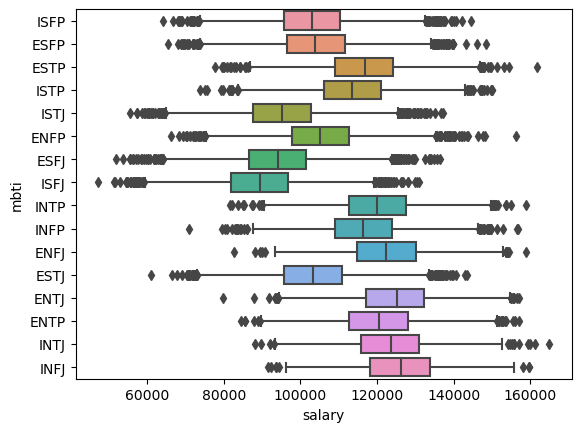

In [17]:
sns.boxplot(y='mbti', x='salary', data=df)